In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import time

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = "cpu"
device

device(type='cuda', index=0)

## Neural Network Model

In [2]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.Sequential(
        nn.Linear(1,10),
        nn.Sigmoid(),
        nn.Linear(10,1, bias=False)
        )
        
    def forward(self, x):
        N = self.layers(x)
        return N

In [3]:
def training(x, loss_fn, optimizer):
    x = x.to(device)
    def closure():
        loss = loss_fn(x)
        optimizer.zero_grad()
        loss.backward()
        return loss
    torch.nn.utils.clip_grad_value_(model.parameters(), 2)
    optimizer.step(closure)   

### Differential equation
$$\frac{d^2\phi(r)}{dr^2} + \frac{2m}{\hbar^2}\left(E-\frac{l(l+1)}{2mr^2}\hbar^2+V(r)\right)\phi(r) = 0$$ 
Dataset are vectors of domain of differential equation, like the vectors are one-dimentional, the shape of dataset is one by m samples. Trial solution $\phi_t(r) = e^{-\beta r^2}N(r,\vec{p})$, with $\phi(r=0) = 0$ and $\phi(r\rightarrow\infty) = 0$ as boundary conditions.  

In [4]:
beta = 2
global Z
Z = 1
global e
#e = -1.602e-19
e = -1
global hbar
#hbar = 1.054e-34
hbar = 1
global m
#m = 9.109e-31
m = 1
global l
l = 0

V = lambda r: -(Z*e**2)/r + r
Phi_t = lambda r: r*torch.exp(-beta*r**2) * model.forward(r)

In [7]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Linear)):
            nn.init.xavier_normal_(m.weight.data)

In [8]:
def loss_fn(r):
    r.requires_grad = True
    
    Phi = Phi_t(r)    
    Phi_t_r = torch.autograd.grad(Phi, r, grad_outputs=torch.ones_like(Phi), create_graph=True)[0]
    Phi_t_r_r = torch.autograd.grad(Phi_t_r, r, grad_outputs=torch.ones_like(Phi_t_r), create_graph=True)[0]
    H_Phi = -(hbar**2/(2*m))*Phi_t_r_r + (l*(l+1)*hbar**2/(2*m*r**2) + V(r))*Phi
    
    norm = torch.trapezoid(Phi[100:]**2,r[100:],dim=0) # integral over r=0 to 6

    prom = Phi.size()[0]
    
    global E
    E = torch.trapezoid(Phi[100:]*H_Phi[100:],r[100:],dim=0)/norm 
    
    
    return (torch.mean((H_Phi[100:] - E*Phi[100:])**2)*prom)/norm #multiply by m to avoit division by m in the mean function of torh 

In [22]:
upper_r = 6
lower_r = -6
steps = 200
R_train = torch.Tensor(np.linspace(lower_r, upper_r, steps)[:,None])
epoch = 10000
lr = 8e-3
Phis_t = []
Es = []
lss = []
epochs = []



start = time.time()

model = NeuralNetwork().to(device)
initialize_weights(model)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
for t in range(epoch+1):
    loss = loss_fn(R_train.to(device))
    print(f"Epoch {t+1}\n ---------------------- loss: {loss}")
    training(R_train, loss_fn, optimizer)
    if t%1 == 0:
        Phis_t.append(Phi_t(R_train.to(device)).data.cpu().numpy())
        Es.append(E.cpu().detach().numpy())
        lss.append(loss.cpu().detach().numpy())
        epochs.append(t)
Es = np.squeeze(Es)
lss = np.squeeze(lss)
Phis_t = np.squeeze(Phis_t)
print("Done!")

end = time.time()
print(end - start)

Epoch 1
 ---------------------- loss: tensor([177.4158], device='cuda:0', grad_fn=<DivBackward0>)
Epoch 2
 ---------------------- loss: tensor([136.4477], device='cuda:0', grad_fn=<DivBackward0>)
Epoch 3
 ---------------------- loss: tensor([134.2099], device='cuda:0', grad_fn=<DivBackward0>)
Epoch 4
 ---------------------- loss: tensor([133.2648], device='cuda:0', grad_fn=<DivBackward0>)
Epoch 5
 ---------------------- loss: tensor([132.6847], device='cuda:0', grad_fn=<DivBackward0>)
Epoch 6
 ---------------------- loss: tensor([132.2667], device='cuda:0', grad_fn=<DivBackward0>)
Epoch 7
 ---------------------- loss: tensor([131.9377], device='cuda:0', grad_fn=<DivBackward0>)
Epoch 8
 ---------------------- loss: tensor([131.6644], device='cuda:0', grad_fn=<DivBackward0>)
Epoch 9
 ---------------------- loss: tensor([131.4290], device='cuda:0', grad_fn=<DivBackward0>)
Epoch 10
 ---------------------- loss: tensor([131.2210], device='cuda:0', grad_fn=<DivBackward0>)
Epoch 11
 ---------

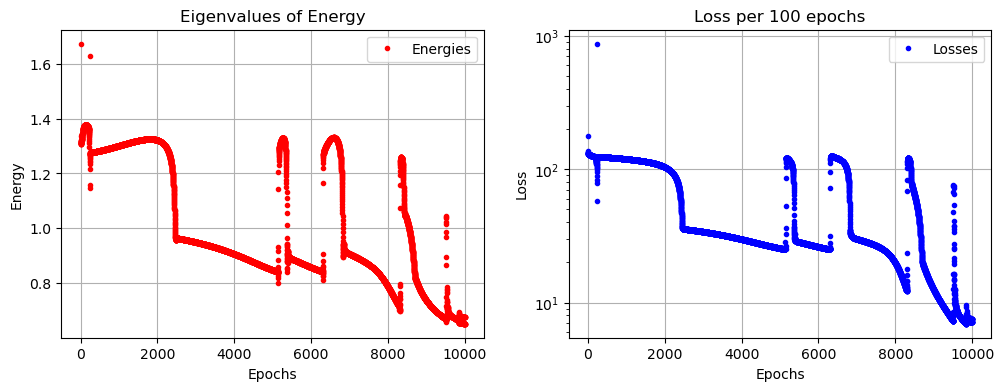

In [23]:
plt.subplots(1,2,figsize=(12,4))
plt.subplot(121)
plt.plot(epochs, Es, "r.", label="Energies")
plt.title("Eigenvalues of Energy")
#plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("Energy")
plt.grid()
plt.legend(loc="best")
plt.subplot(122)
plt.plot(epochs, lss, "b.", label="Losses")
plt.title("Loss per 100 epochs")
plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend(loc="best")
plt.show()

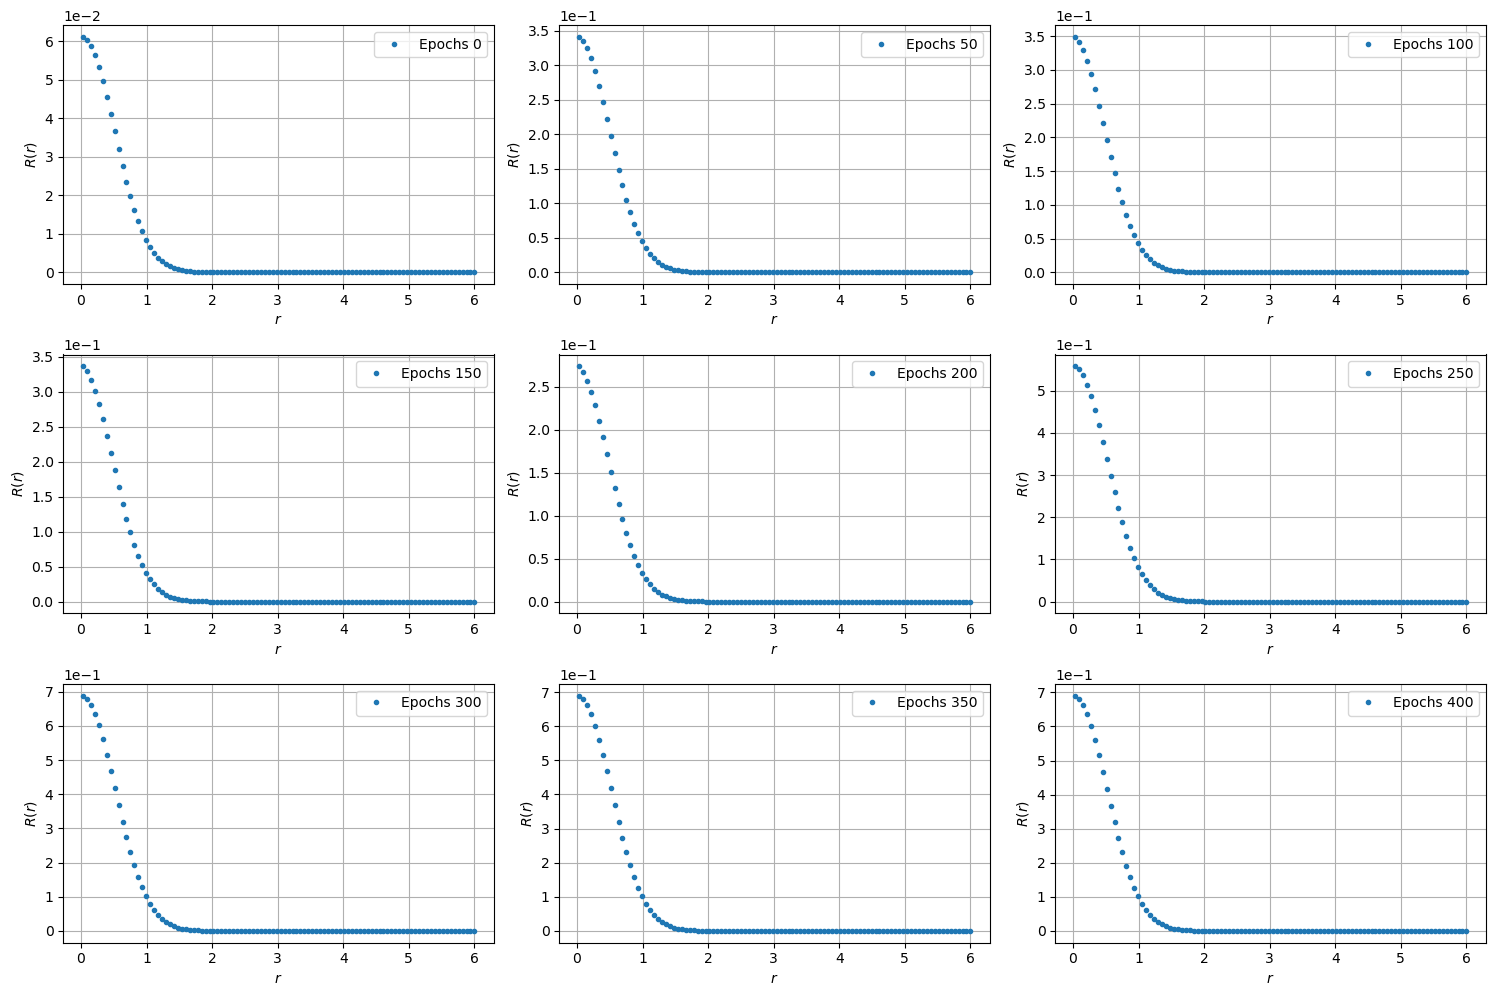

In [24]:
rr = np.linspace(lower_r, upper_r, steps)[:,None]
fig, axs = plt.subplots(3,3,figsize=(15,10))

fil = 0
col = 0
for i in range(0,9):
    yy = Phis_t[50*i]
    yy = yy.reshape((200,1))
    axs[fil,col].plot(rr[100:], np.divide(yy[100:], rr[100:]), ".", label=f"Epochs {epochs[50*i]}")
    axs[fil,col].set_xlabel("$r$")
    axs[fil,col].set_ylabel("$R(r)$")
    axs[fil,col].legend(loc="best")
    axs[fil,col].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    axs[fil,col].grid()
    if col == 2:
       col = 0
       fil = fil+1
    else:
       col = col+1
plt.rc("font", size=8)
plt.tight_layout()
plt.show()  

In [25]:
Es

array([1.6736456 , 1.3373748 , 1.3183837 , ..., 0.6515659 , 0.67456824,
       0.651516  ], dtype=float32)

In [26]:
np.mean(Es)

0.99978596

In [40]:
norm = torch.trapezoid(Phi_t(R_train.to(device)).cpu()[100:]**2,R_train.cpu()[100:],dim=0).detach().numpy()
#norm = norm.detach()
norm

array([4.6465062e-05], dtype=float32)

In [43]:
torch.trapezoid(Phi_t(R_train.to(device)).cpu()[100:]**2,R_train[100:].cpu(),dim=0).detach().numpy()/norm

array([1.], dtype=float32)

In [46]:
Phi_0 = Phi_t(R_train.to(device))
#Phi_0 = Phi_0/torch.sqrt(norm)
Phi_0 = Phi_0.detach()
new = torch.trapezoid(Phi_0.cpu()[100:]**2,R_train.cpu()[100:],dim=0).detach().numpy()
new

array([4.6465062e-05], dtype=float32)

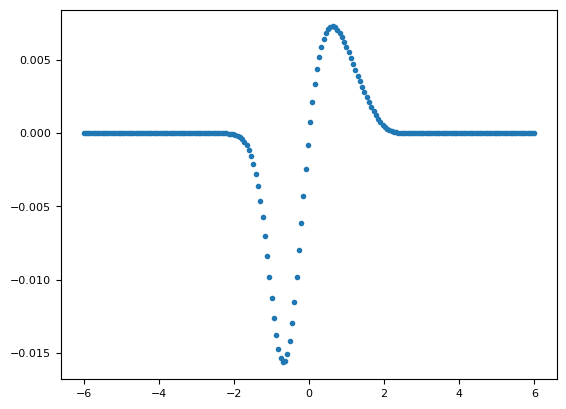

In [48]:
plt.plot(R_train.cpu().detach().numpy(), Phi_0.cpu().detach().numpy(), ".")

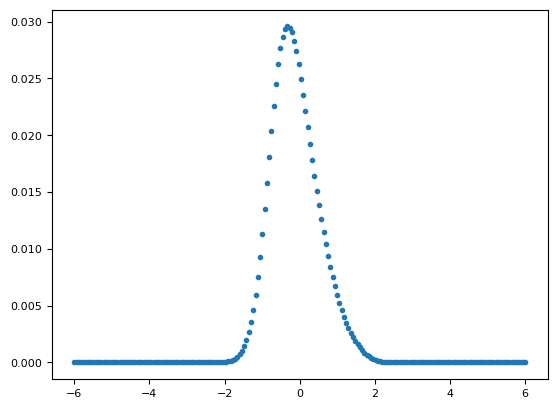

In [52]:
R_0 = torch.divide(Phi_0.to(device), R_train.to(device)).cpu()
plt.plot(R_train.cpu().detach().numpy(), R_0.cpu().detach().numpy(), ".")

In [53]:
norm1 = torch.trapezoid(R_0.to(device)[100:]**2,R_train.to(device)[100:],dim=0).cpu()
norm1 = norm1.detach().numpy()
norm1

array([0.00023914], dtype=float32)

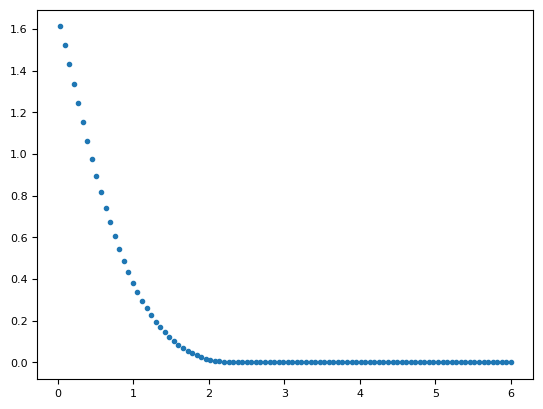

In [59]:
R_0 = R_0/torch.sqrt(torch.tensor(norm1))
plt.plot(R_train.detach().numpy()[100:], R_0.detach().numpy()[100:], ".")

In [60]:
torch.trapezoid(R_0.cpu()[100:]**2,R_train.cpu()[100:],dim=0)

tensor([1.0000])

In [61]:
#file_Phi = open("file1.txt","w")
#for row in Phi_0:
    #np.savetxt(file_Phi, row)
#file_Phi.close() 